In [1]:
%load_ext autoreload
%autoreload 2
!hostname
!pwd
import os, sys
print(sys.executable)
# os.environ['CUDA_VISIBLE_DEVICES'] = "7"
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = "false"
# sys.path.append(os.path.abspath(".."))

slurm0-gpu1nodeset-0
/home/akarsh_sakana_ai/spaghetti/src
/home/akarsh_sakana_ai/.conda/envs/spaghetti/bin/python


In [2]:
import os, sys, glob, pickle, copy, time
from functools import partial

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = (15, 5)
import seaborn as sns
sns.set_theme()

from tqdm.auto import tqdm
from einops import rearrange, reduce, repeat
from einop import einop

import jax
import jax.numpy as jnp
from jax.random import split

import flax
import flax.linen as nn
from flax.training.train_state import TrainState

import optax

In [3]:
from clip import CLIP
from cppn import CPPN, FlattenCPPNParameters
import util

In [4]:
target_img = plt.imread("../skull.jpg")/255.
print(target_img.shape)

(256, 256, 3)


Text(0.5, 1.0, 'Horizontally Flipped')

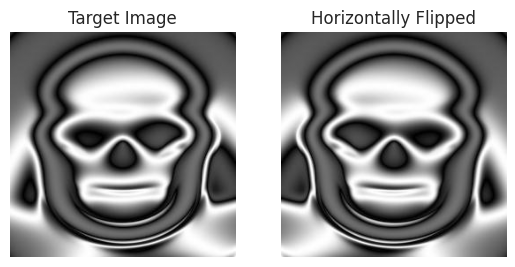

In [20]:
plt.subplot(121); plt.imshow(target_img); plt.axis("off"); plt.title("Target Image")
plt.subplot(122); plt.imshow(target_img[:, ::-1]); plt.axis("off"); plt.title("Horizontally Flipped")

ParameterReshaper: 5453 parameters detected for optimization.


  0%|          | 0/500000 [00:00<?, ?it/s]

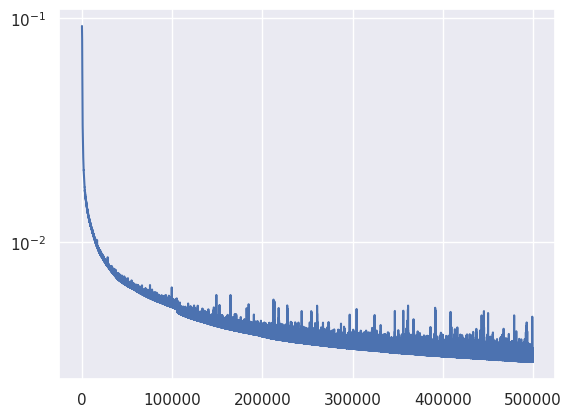

In [93]:
from cppn import CPPN, FlattenCPPNParameters
cppn = CPPN(3, 50, nonlin='relu')
cppn = FlattenCPPNParameters(cppn)

rng = jax.random.PRNGKey(0)
params_sgd = cppn.init(rng, jnp.zeros((3,)))
# params_sgd = jax.random.normal(rng, (cppn.n_params,))

def loss_fn(params, target_img):
    img = cppn.generate_image(params, img_size=256)
    return jnp.mean((img - target_img)**2)

@jax.jit
def train_step(state, _):
    img = cppn.generate_image(state.params)
    loss, grad = jax.value_and_grad(loss_fn)(state.params, target_img)
    state = state.apply_gradients(grads=grad)
    return state, loss

tx = optax.adam(learning_rate=3e-4)
state = TrainState.create(apply_fn=None, params=params_sgd, tx=tx)

losses = []
for t in tqdm(range(500000)):
    state, loss = train_step(state, None)
    # state, loss = jax.lax.scan(train_step, state, None, length=1000)
    losses.append(loss)
losses = np.array(jnp.stack(losses))

params_sgd = state.params

plt.plot(losses)
plt.yscale("log")
plt.show()


loss:  0.003014741


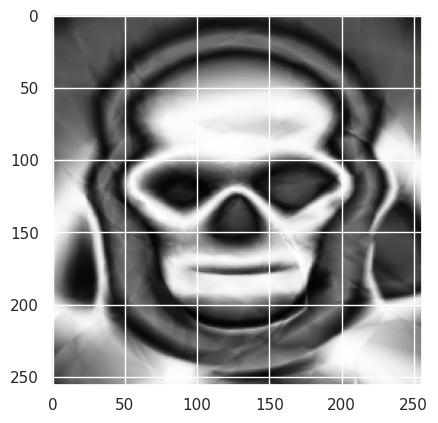

In [94]:
img = cppn.generate_image(params_sgd, img_size=256)
print("loss: ", ((img-target_img)**2).mean())
plt.imshow(img)

In [95]:
params

Array([ 0.00368204, -0.22312388,  0.8010259 , ...,  1.7821614 ,
        1.7821497 ,  1.7821702 ], dtype=float32)

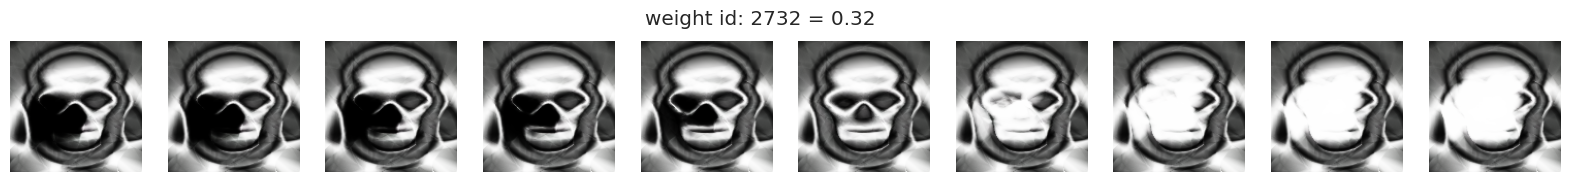

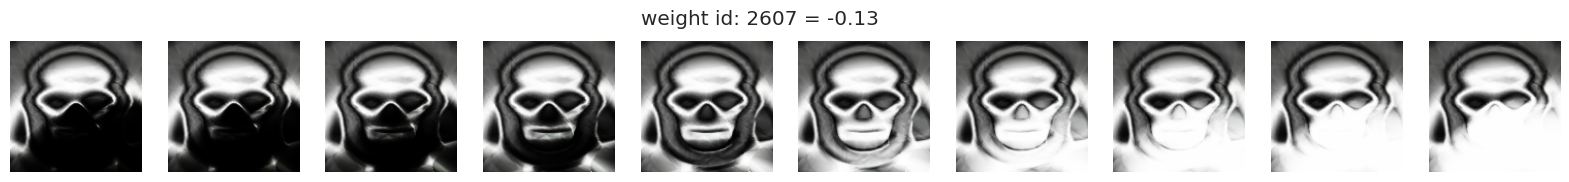

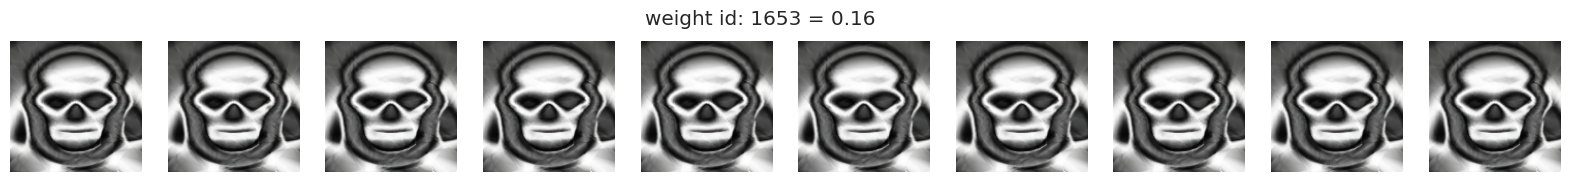

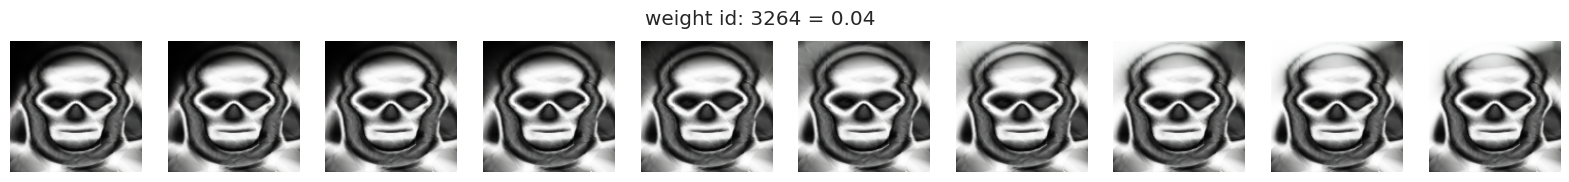

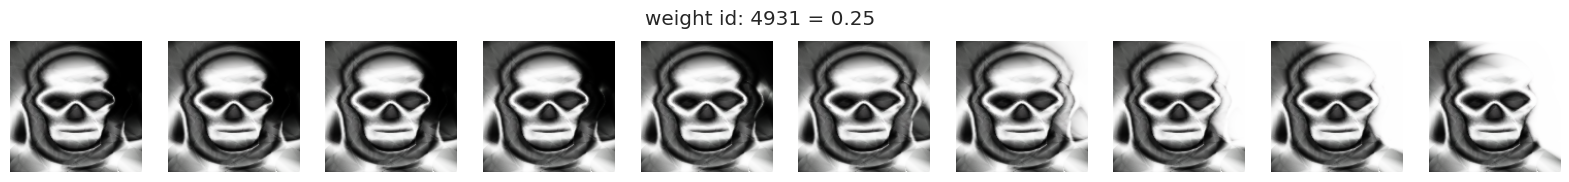

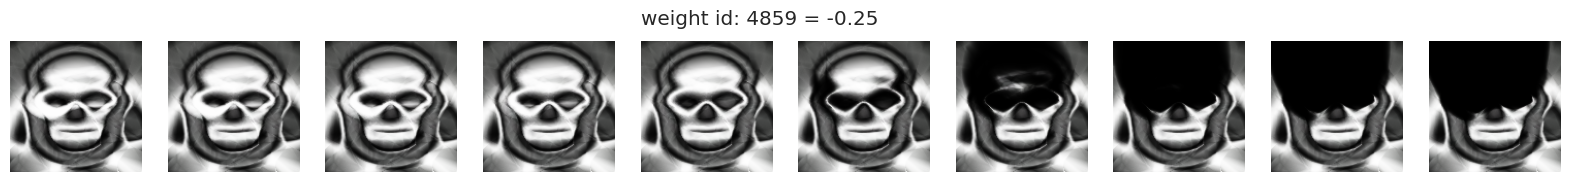

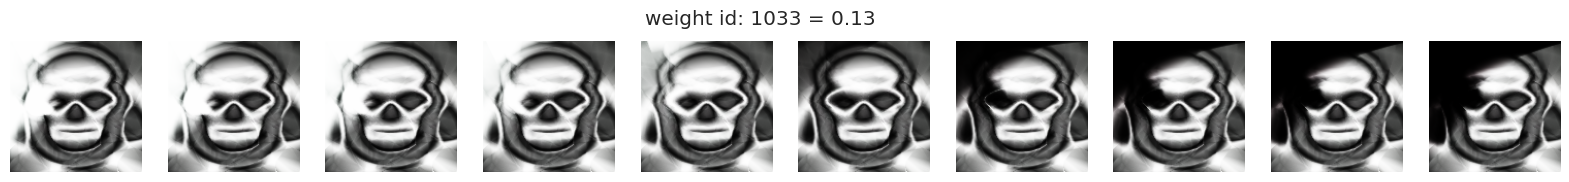

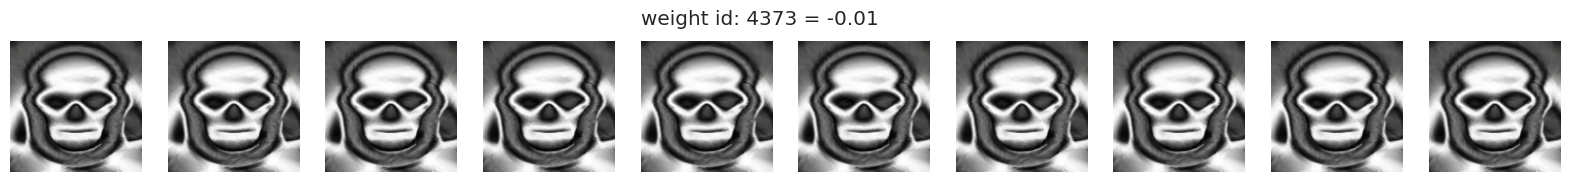

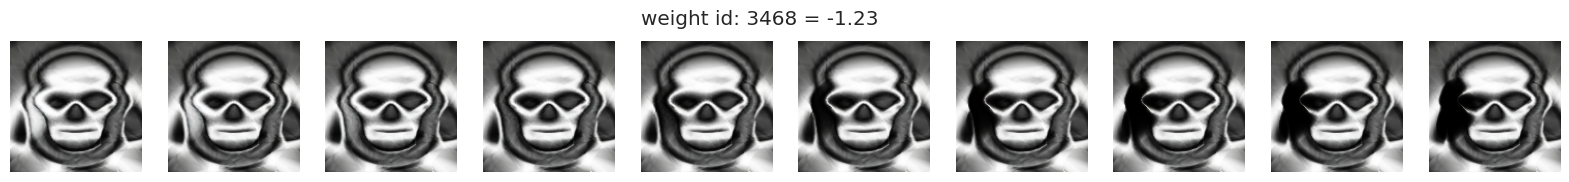

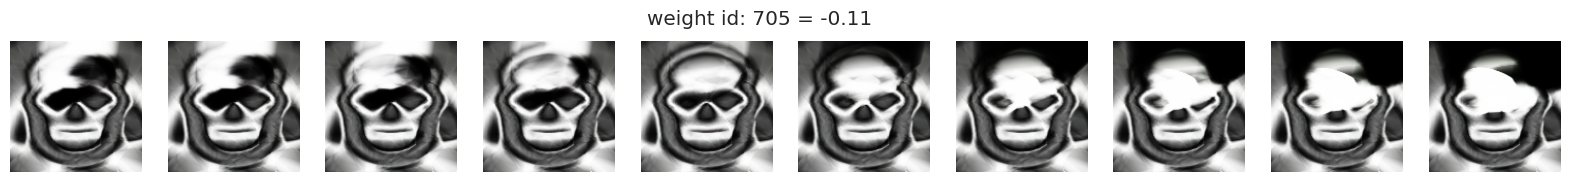

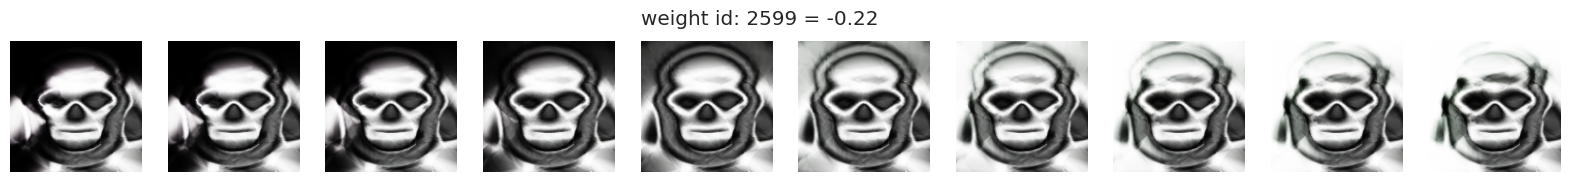

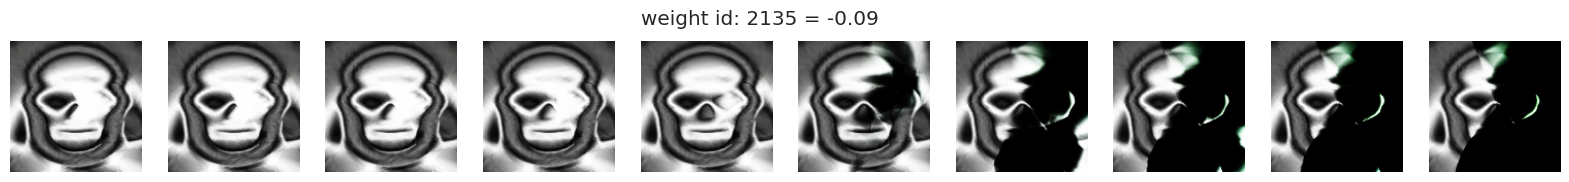

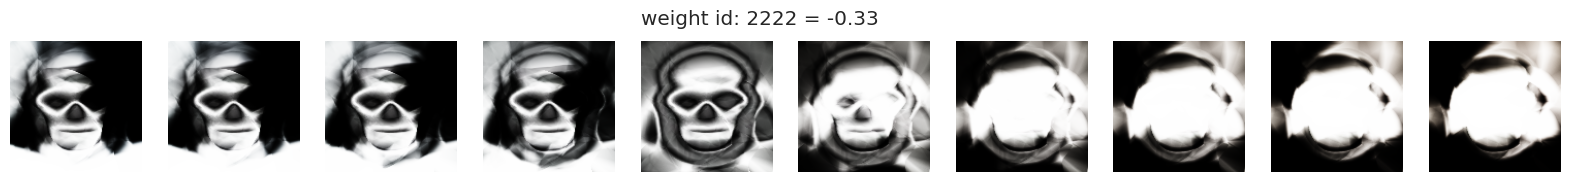

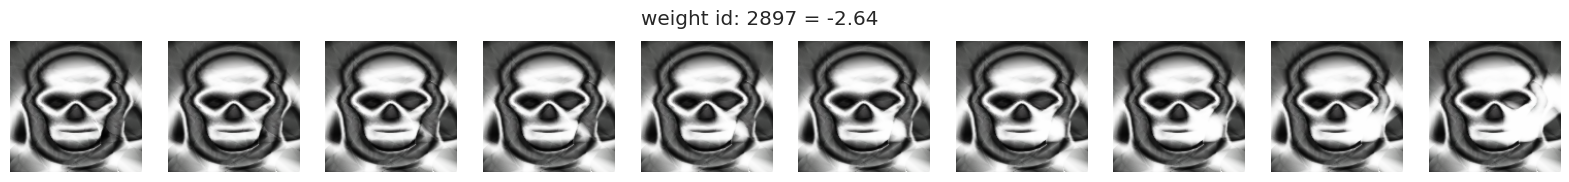

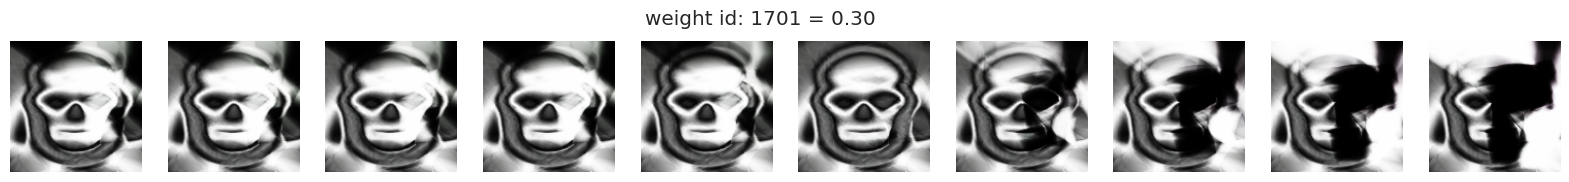

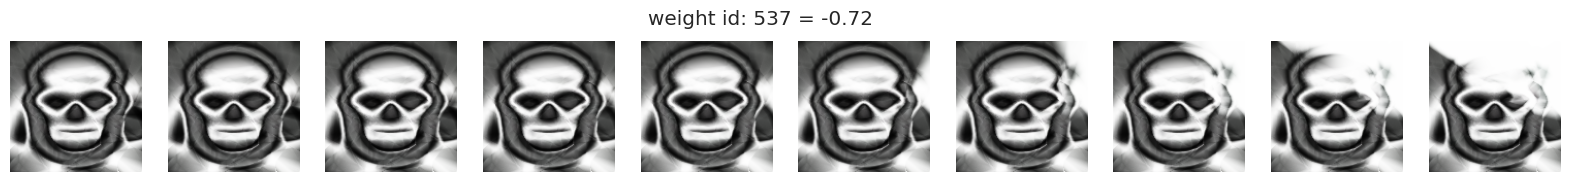

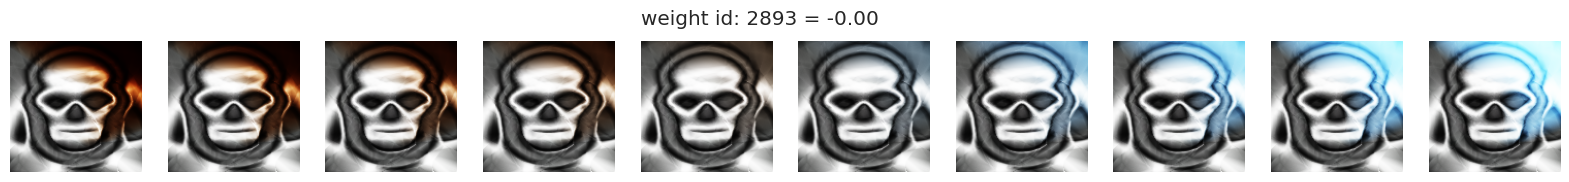

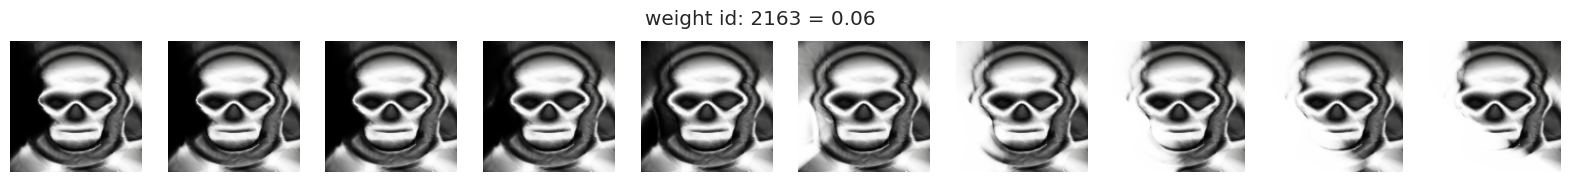

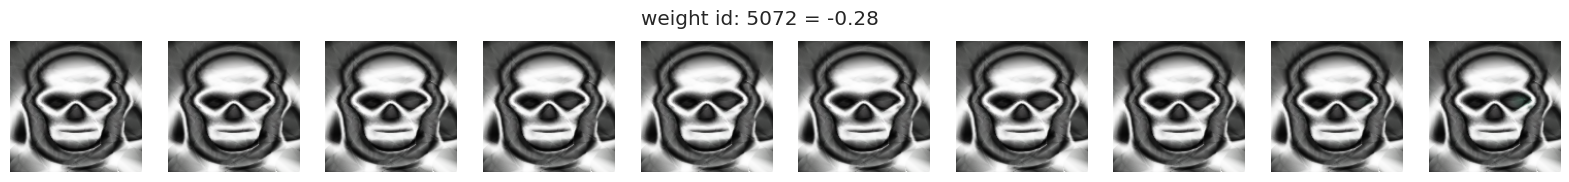

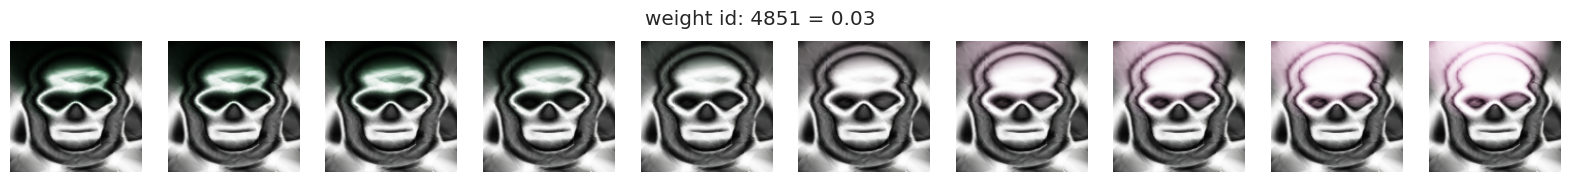

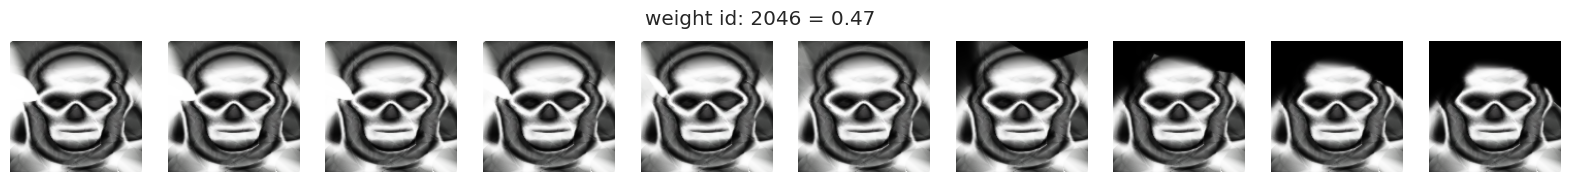

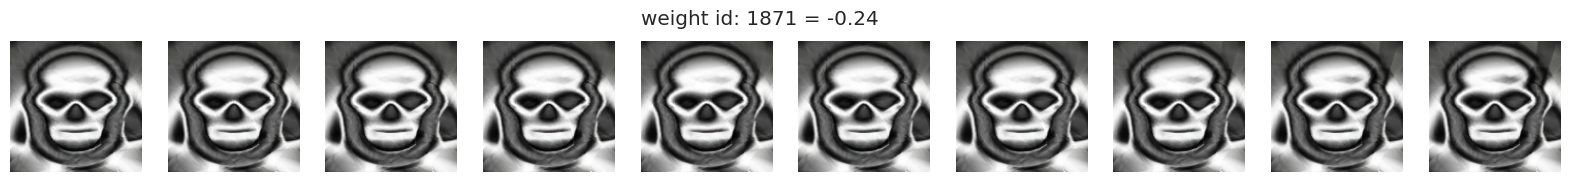

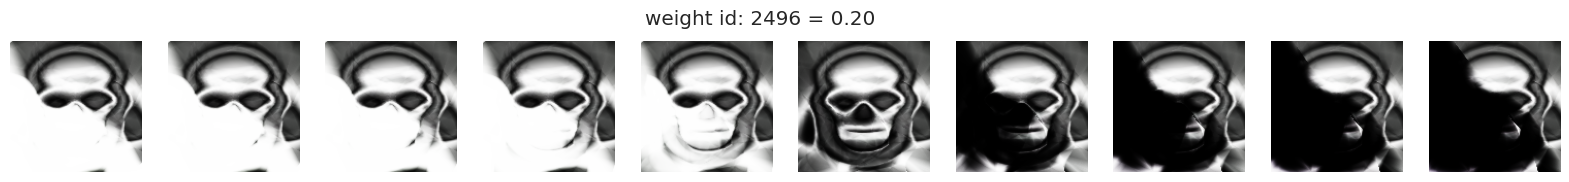

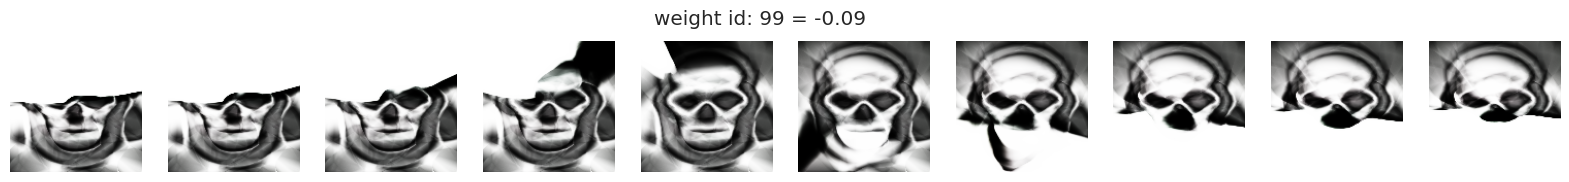

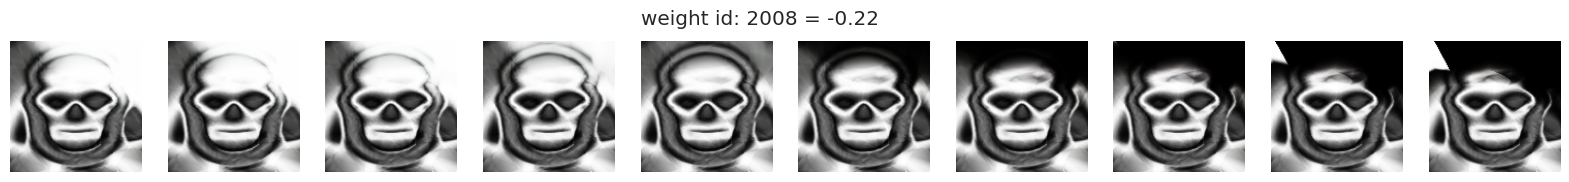

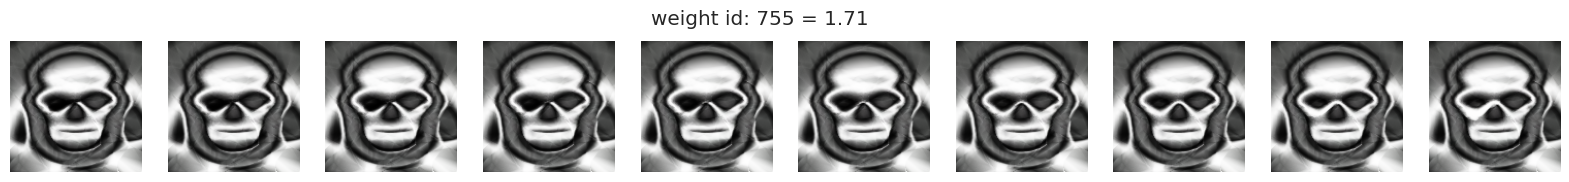

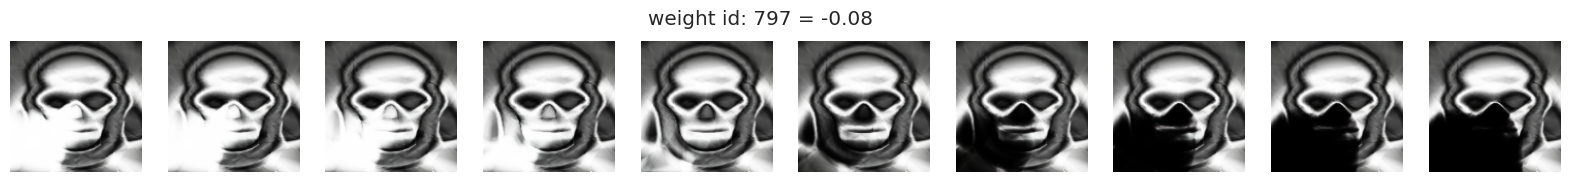

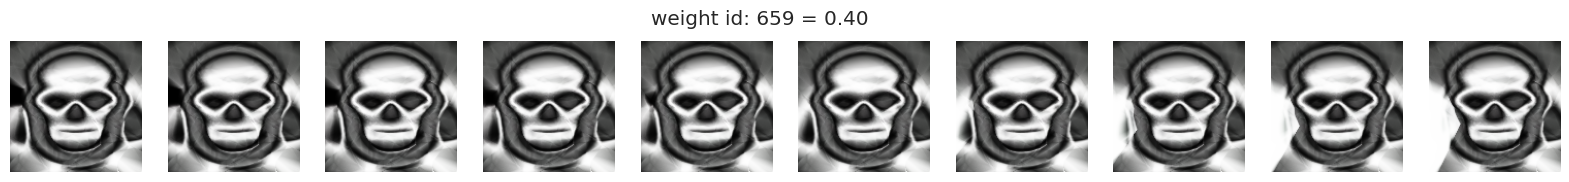

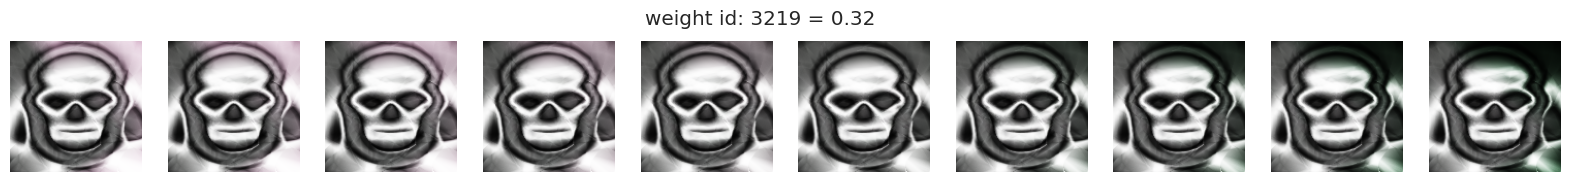

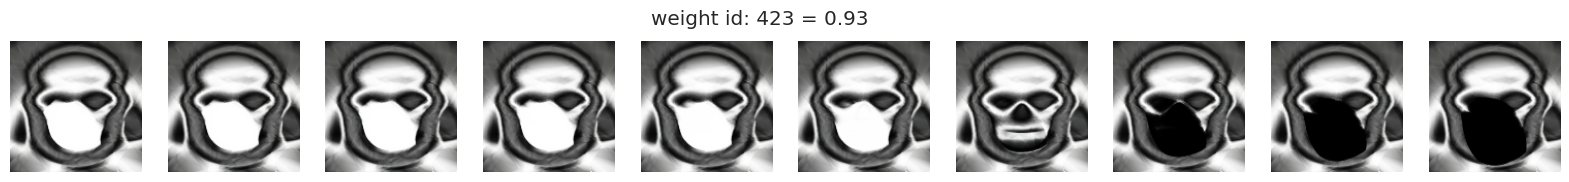

In [96]:
params = params_sgd
np.random.seed(0)

for _ in range(30):
    weight_id = np.random.randint(cppn.n_params)

    plt.figure(figsize=(20, 2))
    for i, val in enumerate(np.linspace(-3, 3, 10)):
        params_p = params.at[weight_id].set(val)
        img = cppn.generate_image(params_p)
        plt.subplot(1, 10, i+1); plt.imshow(img); plt.axis('off')
    ori_val = params[weight_id].item()
    plt.suptitle(f"weight id: {weight_id} = {ori_val:.2f}")
    plt.show()